<a href="https://colab.research.google.com/github/anushka1947/Machine-Learning/blob/main/AI_Based_Flight_Data_Recorder_Analysis_for_Anomaly_Detection_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files
df=files.upload()


Saving modified_flight_data.csv to modified_flight_data.csv


In [ ]:
df=pd.read_csv('modified_flight_data.csv')
df.head()

,time,altitude,airspeed,vertical_speed,engine_temperature,fuel_flow,pitch,roll,anomaly,latitude,longitude,outside_temp,wind_speed,acceleration,jerk
0,0,35248.357077,486.430105,174.143124,540.582841,4.528142,0.491031,0.394189,0,30.005967,74.994215,-38.258569,20.291420,0.000000,0.000000
1,1,34930.867849,493.890011,141.661796,568.350431,6.012702,-0.320541,2.814487,0,30.005584,74.992160,-38.583382,34.175215,7.459905,7.459905
2,2,35323.844269,488.052379,-468.259923,582.389148,4.801813,4.758954,1.705510,0,30.013061,74.987186,-44.682599,41.194574,-5.837632,-13.297537
3,3,35761.514928,502.208361,289.792111,604.490067,5.090569,7.664156,-6.389571,0,30.029292,74.989290,-37.102079,52.245034,14.155982,19.993614
4,4,34882.923313,523.943571,-745.041338,630.724870,5.717391,3.434235,-0.931102,0,30.027950,75.002262,-47.450413,65.362435,21.735210,7.579228


Data Preprocessingg

In [ ]:
print(df.isnull().sum())

time                  0
altitude              0
airspeed              0
vertical_speed        0
engine_temperature    0
fuel_flow             0
pitch                 0
roll                  0
anomaly               0
latitude              0
longitude             0
outside_temp          0
wind_speed            0
acceleration          0
jerk                  0
dtype: int64


In [ ]:
df.dropna(inplace=True)
scaler = MinMaxScaler()


In [ ]:
drop_columns = ['anomaly'] if 'anomaly' in df.columns else []
df_scaled = pd.DataFrame(scaler.fit_transform(df.drop(columns=drop_columns, errors='ignore')),
columns=df.drop(columns=drop_columns, errors='ignore').columns)

In [ ]:
if 'airspeed' in df_scaled.columns:
    df_scaled['rolling_mean'] = df_scaled['airspeed'].rolling(window=5).mean().fillna(0)
    df_scaled['rolling_var'] = df_scaled['airspeed'].rolling(window=5).var().fillna(0)
if 'acceleration' in df_scaled.columns:
    df_scaled['jerk'] = df_scaled['acceleration'].diff().fillna(0)


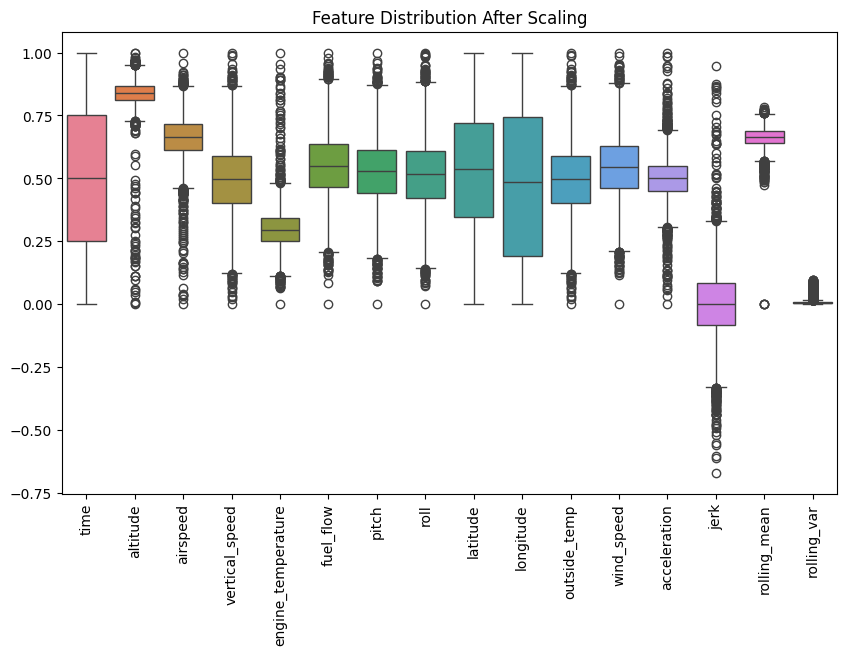

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_scaled)
plt.title("Feature Distribution After Scaling")
plt.xticks(rotation=90)
plt.show()

In [ ]:
print("\nApplying Isolation Forest for Anomaly Detection...")
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
df_scaled['isolation_anomaly'] = isolation_forest.fit_predict(df_scaled)
df_scaled['isolation_anomaly'] = df_scaled['isolation_anomaly'].map({1: 0, -1: 1})
print(f"Anomalies detected by Isolation Forest: {df_scaled['isolation_anomaly'].sum()}")


Applying Isolation Forest for Anomaly Detection...
Anomalies detected by Isolation Forest: 500


In [ ]:
print("\nTraining Autoencoder for Anomaly Detection...")
input_dim = df_scaled.shape[1] - 1
encoding_dim = 8



Training Autoencoder for Anomaly Detection...


In [ ]:
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)
autoencoder = keras.Model(input_layer, decoded)


In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(df_scaled.drop(columns=['isolation_anomaly']), df_scaled.drop(columns=['isolation_anomaly']),
epochs=50, batch_size=32, shuffle=True, verbose=1)


Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0502
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0176
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0105
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0086
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0078
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0065
Epoch 9/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0055
Epoch 10/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0050
Epoch 11/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0047
Epoch 12/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0044
Epoch 13/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0042
Epoch 14/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0040
Epoch 15/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

In [ ]:
print("Reconstruction Shape:", reconstructions.shape)
print("Original Input Shape:", df_scaled.drop(columns=['isolation_anomaly']).shape)



Reconstruction Shape: (10000, 16)
Original Input Shape: (10000, 17)


In [ ]:
print("\nPerformance Metrics:")
y_true = df_scaled['hybrid_anomaly']
y_pred = df_scaled['autoencoder_anomaly']
print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
print(f"Precision: {precision_score(y_true, y_pred):.2f}")
print(f"Recall: {recall_score(y_true, y_pred):.2f}")
print(f"F1 Score: {f1_score(y_true, y_pred):.2f}")



Performance Metrics:
Accuracy: 0.97
Precision: 1.00
Recall: 0.62
F1 Score: 0.77


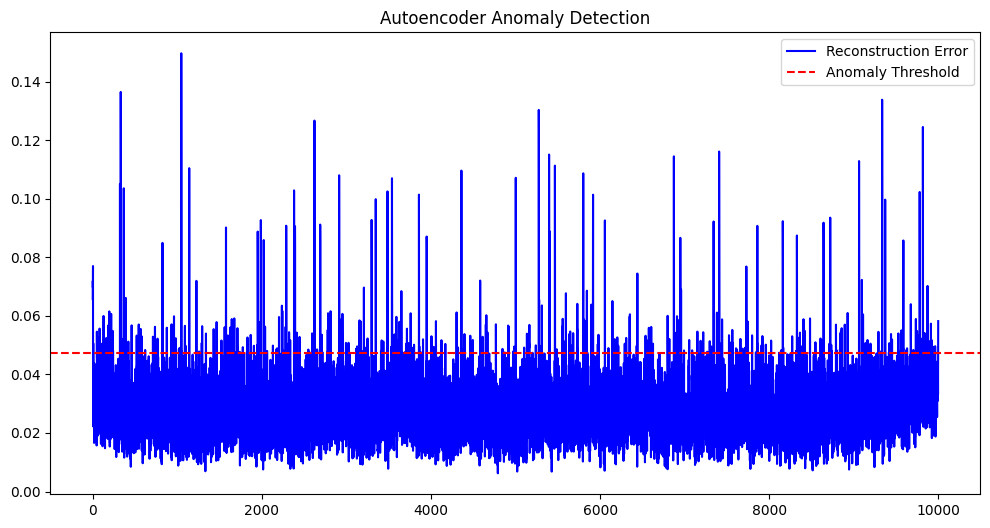

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_scaled.index, mse, label='Reconstruction Error', color='blue')
plt.axhline(thresh, color='red', linestyle='--', label='Anomaly Threshold')
plt.legend()
plt.title("Autoencoder Anomaly Detection")
plt.show()


In [2]:
print("\nPotential DRDO Applications:")
print("1. Here I'm Using AI Hybrid Approach in UAV Flight Anomaly Detection ")
print("2. For Predictive Maintenance in  Avionic Systems using Deep Learning")
print("3.In Real-time Aircraft Health Monitoring ,here i'm using  Hybrid AI Techniques")



Potential DRDO Applications:
1. Here I'm Using AI Hybrid Approach in UAV Flight Anomaly Detection 
2. For Predictive Maintenance in  Avionic Systems using Deep Learning
3.In Real-time Aircraft Health Monitoring ,here i'm using  Hybrid AI Techniques
